# Relationships between distance and mutational fraction and mutation fraction ratios

# Setup

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tabulate import tabulate
import py3Dmol

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
    plot_scatter_w_best_fit_line,
)
from dms_3d_features.format_tables import (
    dataframe_column_table,
    generate_threshold_summary,
)

In [124]:
# Function to create scatter plot with linear regression for distance vs reactivity analysis
def create_scatter_plot_w_regression(df, ax, x_col, y_col, color_by_pdb_res=False):
    # Prepare the data
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Compute R-squared
    r2 = r2_score(y, model.predict(X))

    if color_by_pdb_res:
        scatter = ax.scatter(X.flatten(), y, s=6, c=df["pdb_res"], cmap="viridis")
        plt.colorbar(scatter, ax=ax, label="PDB Residue")
    else:
        ax.scatter(X.flatten(), y, s=6)

    # Add regression line
    ax.plot(X, model.predict(X), color="black", linewidth=1)

    return r2


## Load data


In [125]:
DATA_PATH = "../data"

In [126]:
df_corr = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_reactivity_correlation.csv"
)
df_corr_data = pd.read_csv(f"{DATA_PATH}/pdb-features/non_canonical_atom_distances.csv")
df_ratio_corr = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_reactivity_ratio_correlation.csv"
)
df_ratio_corr_data = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_with_ratio.csv"
)

# Reactivity correlations

## A-A correlations

In [127]:
# Filter for A-A pair and sort by r2 in descending order
df_aa = df_corr[df_corr["pair"] == "A-A"].sort_values(by="r2", ascending=False)
# Select top 20 rows
top_20_aa = df_aa.head(20)
# Create a table using tabulate
table = tabulate(
    top_20_aa[["atom1", "atom2", "r2", "count"]],
    headers=["Atom 1", "Atom 2", "R2", "Count"],
    tablefmt="pipe",
    floatfmt=".4f",
)
print("Top 20 atom pairs for A-A:")
print(table)

Top 20 atom pairs for A-A:
|     | Atom 1   | Atom 2   |     R2 |   Count |
|----:|:---------|:---------|-------:|--------:|
| 235 | N1       | O2'      | 0.1942 |      66 |
| 187 | C6       | N3       | 0.1895 |      69 |
| 191 | C6       | O2'      | 0.1890 |      66 |
| 350 | O2'      | OP2      | 0.1795 |      66 |
| 143 | C5       | N3       | 0.1773 |      69 |
| 147 | C5       | O2'      | 0.1708 |      66 |
| 103 | C4       | O2'      | 0.1688 |      66 |
| 342 | O2'      | N6       | 0.1673 |      66 |
| 100 | C4       | N6       | 0.1657 |      69 |
|  99 | C4       | N3       | 0.1609 |      69 |
| 343 | O2'      | N7       | 0.1602 |      66 |
| 178 | C6       | C2'      | 0.1601 |      69 |
| 279 | N6       | O2'      | 0.1589 |      66 |
|  42 | C2       | OP2      | 0.1532 |      69 |
| 133 | C5       | C2       | 0.1527 |      69 |
| 222 | N1       | C2'      | 0.1517 |      69 |
| 275 | N6       | N3       | 0.1499 |      69 |
| 254 | N3       | N6       | 0.1482 |    

In [128]:
df_corr_data_aa = df_corr_data.query(
    'pair == "A-A" and atom1 == "N1" and atom2 == "O2\'"'
).copy()
df_corr_data_aa.sort_values(by="distance", ascending=False, inplace=True)

In [129]:
# Create a table using tabulate for A-A pair with N1 and O2' atoms
table_aa = tabulate(
    df_corr_data_aa[
        ["pdb_name", "distance", "ln_r_data_mean", "pdb_r_pos", "pdb_r_bp_type"]
    ],
    headers=["PDB", "Distance", "ln_r_data", "Res. Pos.", "BP Type"],
    tablefmt="pipe",
    floatfmt=".4f",
    showindex=False,
)
print("Top 20 entries for A-A pair with N1 and O2' atoms:")
print(table_aa)

Top 20 entries for A-A pair with N1 and O2' atoms:
| PDB                                                                  |   Distance |   ln_r_data |   Res. Pos. | BP Type   |
|:---------------------------------------------------------------------|-----------:|------------:|------------:|:----------|
| data/pdbs_w_2bp/AAG_CAU/NWAY.3HOY.1-0-0-0.AAG-DA-DC-DT.0.pdb         |    11.9200 |     -4.4885 |          11 | cHW       |
| data/pdbs_w_2bp/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.1.pdb                |    11.7100 |     -4.3643 |          11 | cHW       |
| data/pdbs_w_2bp/CAG_CAG/TWOWAY.4J50.1-1.CAG-CAG.2.pdb                |    11.7100 |     -4.5316 |           4 | cWH       |
| data/pdbs_w_2bp/CGACGAAG_CAGAG/TWOWAY.4KQY.3-6.CAGAG-CGACGAAG.0.pdb  |    11.4900 |     -5.2598 |          16 | tSH       |
| data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0.AAUA-UUAGUAC-GG.0.pdb |    10.6800 |     -5.4057 |           5 | tHH       |
| data/pdbs_w_2bp/AAACG_CUAU/TWOWAY.1NJP.2-3.CUAU-AAACG.0.pdb      

## A-G correlations

In [130]:
# Filter for A-G pair and sort by r2 in descending order
df_aa = df_corr[df_corr["pair"] == "A-G"].sort_values(by="r2", ascending=False)
# Select top 20 rows
top_20_aa = df_aa.head(20)
# Create a table using tabulate
table = tabulate(
    top_20_aa[["atom1", "atom2", "r2", "count"]],
    headers=["Atom 1", "Atom 2", "R2", "Count"],
    tablefmt="pipe",
    floatfmt=".4f",
)
print("Top 20 atom pairs for A-G:")
print(table)

Top 20 atom pairs for A-G:
|     | Atom 1   | Atom 2   |     R2 |   Count |
|----:|:---------|:---------|-------:|--------:|
| 966 | OP2      | P        | 0.5186 |     122 |
| 952 | OP2      | C6       | 0.5100 |     122 |
| 975 | P        | C6       | 0.5076 |     122 |
| 989 | P        | P        | 0.5069 |     122 |
| 950 | OP2      | C5       | 0.5063 |     122 |
| 929 | OP1      | C6       | 0.5058 |     122 |
| 965 | OP2      | OP2      | 0.5056 |     122 |
| 943 | OP1      | P        | 0.5042 |     122 |
| 954 | OP2      | N1       | 0.5026 |     122 |
| 962 | OP2      | O5'      | 0.5019 |     122 |
| 942 | OP1      | OP2      | 0.5005 |     122 |
| 973 | P        | C5       | 0.4992 |     122 |
| 948 | OP2      | C4       | 0.4978 |     122 |
| 988 | P        | OP2      | 0.4975 |     122 |
| 964 | OP2      | OP1      | 0.4972 |     122 |
| 927 | OP1      | C5       | 0.4971 |     122 |
| 931 | OP1      | N1       | 0.4934 |     122 |
| 977 | P        | N1       | 0.4925 |    

In [131]:
df_corr_data_ag = df_corr_data.query(
    'pair == "A-G" and atom1 == "P" and atom2 == "P"'
).copy()
df_corr_data_ag.sort_values(by="distance", ascending=False, inplace=True)

In [132]:
df_corr_data_ag.columns

Index(['pdb_name', 'pdb_r_pos', 'pair_pdb_r_pos', 'pdb_r_bp_type', 'distance',
       'average_b_factor', 'normalized_b_factor', 'pdb_res', 'ln_r_data_mean',
       'ln_r_data_std', 'pair', 'atom1', 'atom2', 'r2'],
      dtype='object')

In [133]:
# Create a table using tabulate for A-A pair with N1 and O2' atoms
table_ag = tabulate(
    df_corr_data_ag[["pdb_name", "distance", "ln_r_data_mean"]],
    headers=["PDB", "Distance", "ln_r_data"],
    tablefmt="pipe",
    floatfmt=".4f",
    showindex=False,
)
print("Top 20 entries for A-G pair with P and P atoms:")
print(table_ag)

Top 20 entries for A-G pair with P and P atoms:
| PDB                                                                       |   Distance |   ln_r_data |
|:--------------------------------------------------------------------------|-----------:|------------:|
| data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb                 |    21.3700 |     -4.7717 |
| data/pdbs_w_2bp/GAGG_CAC/TWOWAY.1XJR.1-2.CAC-GAGG.0.pdb                   |    21.3500 |     -4.9871 |
| data/pdbs_w_2bp/AAU_AGU/TWOWAY.5XYI.1-1.AGU-AAU.0.pdb                     |    21.0500 |     -5.9101 |
| data/pdbs_w_2bp/GAUGG_CAC/TWOWAY.3MXH.1-3.CAC-GAUGG.0.pdb                 |    21.0400 |     -4.4944 |
| data/pdbs_w_2bp/GGGA_UAAC/TWOWAY.5O5J.2-2.UAAC-GGGA.0.pdb                 |    20.8700 |     -5.5212 |
| data/pdbs_w_2bp/GGAC_GGAC/TWOWAY.5LQO.2-2.GGAC-GGAC.0.pdb                 |    20.8100 |     -4.6242 |
| data/pdbs_w_2bp/GGAC_GGAC/TWOWAY.5LQO.2-2.GGAC-GGAC.0.pdb                 |    20.5200 |     -4.7987 |
| data/

data/pdbs_w_2bp/UGAGG_UGGAG/TWOWAY.6YS3.3-3.UGAGG-UGGAG.0.pdb<br>
data/pdbs_w_2bp/GGGAGC_GGGAGC/TWOWAY.1D4R.4-4.GGGAGC-GGGAGC.0.pdb<br>
data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb<br>

0.5068710179916276


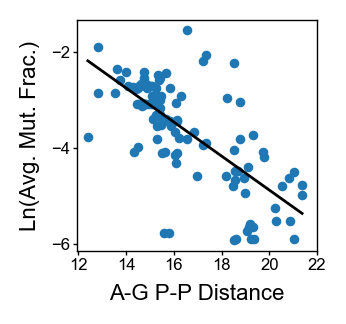

In [134]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_corr_data_ag, ax, "distance", "ln_r_data_mean")

ax.set_xlabel("A-G P-P Distance")
ax.set_ylabel("Ln(Avg. Mut. Frac.)")
ax.set_xticks([12, 14, 16, 18, 20, 22])
format_small_plot(ax)
print(r2)

## C-A correlations

In [135]:
df_ca = df_corr[df_corr["pair"] == "C-A"].sort_values(by="r2", ascending=False)
# Select top 20 rows
top_20_ca = df_ca.head(20)
# Create a table using tabulate
table = tabulate(
    top_20_ca[["atom1", "atom2", "r2", "count"]],
    headers=["Atom 1", "Atom 2", "R2", "Count"],
    tablefmt="pipe",
    floatfmt=".4f",
)
print("Top 20 atom pairs for C-A:")
print(table)

Top 20 atom pairs for C-A:
|      | Atom 1   | Atom 2   |     R2 |   Count |
|-----:|:---------|:---------|-------:|--------:|
| 1300 | O3'      | C2'      | 0.5139 |      48 |
| 1058 | C3'      | C2'      | 0.4964 |      48 |
| 1298 | O3'      | C1'      | 0.4913 |      48 |
| 1309 | O3'      | N3       | 0.4768 |      48 |
| 1034 | C2'      | C1'      | 0.4645 |      48 |
| 1036 | C2'      | C2'      | 0.4624 |      48 |
| 1313 | O3'      | O2'      | 0.4584 |      48 |
| 1056 | C3'      | C1'      | 0.4529 |      48 |
| 1067 | C3'      | N3       | 0.4265 |      48 |
| 1314 | O3'      | O3'      | 0.4183 |      48 |
| 1299 | O3'      | C2       | 0.4166 |      48 |
| 1102 | C4'      | C2'      | 0.4074 |      48 |
| 1060 | C3'      | C4       | 0.4065 |      48 |
| 1278 | O2'      | C2'      | 0.4022 |      48 |
| 1302 | O3'      | C4       | 0.4017 |      48 |
| 1276 | O2'      | C1'      | 0.3992 |      48 |
| 1050 | C2'      | O3'      | 0.3955 |      48 |
| 1291 | O2'      | O2'

In [136]:
df_corr_data_ca = df_corr_data.query(
    'pair == "C-A" and atom1 == "O3\'" and atom2 == "C2\'"'
).copy()
df_corr_data_ca.sort_values(by="distance", ascending=False, inplace=True)

In [137]:
# Create a table using tabulate for A-A pair with N1 and O2' atoms
table_ca = tabulate(
    df_corr_data_ca[
        ["pdb_name", "distance", "ln_r_data_mean", "pdb_r_pos", "pdb_r_bp_type"]
    ],
    headers=["PDB", "Distance", "ln_r_data", "Res. Pos.", "BP Type"],
    tablefmt="pipe",
    floatfmt=".4f",
    showindex=False,
)
print("Top 20 entries for C-A pair with C and C atoms:")
print(table_ca)

Top 20 entries for C-A pair with C and C atoms:
| PDB                                                                |   Distance |   ln_r_data |   Res. Pos. | BP Type   |
|:-------------------------------------------------------------------|-----------:|------------:|------------:|:----------|
| data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb          |    15.2900 |     -2.4071 |           4 | cWW       |
| data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD5.4-4.UCACAG-UCACAG.0.pdb  |    15.0700 |     -3.1384 |          16 | cWH       |
| data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD5.4-4.UCACAG-UCACAG.0.pdb  |    15.0100 |     -3.2741 |           6 | cWH       |
| data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD4.4-4.UCACAG-UCACAG.0.pdb  |    14.5600 |     -3.1384 |          16 | cWH       |
| data/pdbs_w_2bp/UCACAG_UCACAG/TWOWAY.1KD4.4-4.UCACAG-UCACAG.0.pdb  |    14.3900 |     -3.2741 |           6 | cWH       |
| data/pdbs_w_2bp/ACG_CAU/TWOWAY.4M4O.1-1.ACG-CAU.0.pdb              |    14.1900 | 

plot examples<br>
data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb<br>
data/pdbs_w_2bp/AAC_GCU/TWOWAY.7JQC.1-1.AAC-GCU.0.pdb<br>
data/pdbs_w_2bp/AAGCAG_UCAGGU/TWOWAY.1LNT.4-4.UCAGGU-AAGCAG.0.pdb<br>

0.5139449403790017


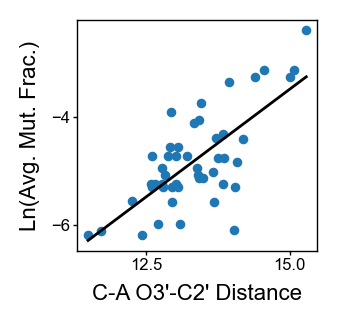

In [138]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_corr_data_ca, ax, "distance", "ln_r_data_mean")

ax.set_xlabel("C-A O3'-C2' Distance")
ax.set_ylabel("Ln(Avg. Mut. Frac.)")
format_small_plot(ax)
print(r2)

## C-C correlations

In [139]:
# Filter for C-C pair and sort by r2 in descending order
df_cc = df_corr[df_corr["pair"] == "C-C"].sort_values(by="r2", ascending=False)
# Select top 20 rows
top_20_cc = df_cc.head(20)
# Create a table using tabulate
table = tabulate(
    top_20_cc[["atom1", "atom2", "r2", "count"]],
    headers=["Atom 1", "Atom 2", "R2", "Count"],
    tablefmt="pipe",
    floatfmt=".4f",
)
print("Top 20 atom pairs for C-C:")
print(table)

Top 20 atom pairs for C-C:
|      | Atom 1   | Atom 2   |     R2 |   Count |
|-----:|:---------|:---------|-------:|--------:|
| 1728 | O3'      | OP2      | 0.6366 |      35 |
| 1488 | C2'      | OP2      | 0.6237 |      35 |
| 1508 | C3'      | OP2      | 0.6182 |      35 |
| 1708 | O2'      | OP2      | 0.6057 |      35 |
| 1729 | O3'      | P        | 0.6001 |      35 |
| 1489 | C2'      | P        | 0.5907 |      35 |
| 1448 | C1'      | OP2      | 0.5878 |      35 |
| 1548 | C4'      | OP2      | 0.5834 |      35 |
| 1509 | C3'      | P        | 0.5771 |      35 |
| 1709 | O2'      | P        | 0.5754 |      35 |
| 1748 | O4'      | OP2      | 0.5673 |      35 |
| 1628 | N1       | OP2      | 0.5606 |      35 |
| 1449 | C1'      | P        | 0.5535 |      35 |
| 1468 | C2       | OP2      | 0.5523 |      35 |
| 1549 | C4'      | P        | 0.5452 |      35 |
| 1727 | O3'      | OP1      | 0.5449 |      35 |
| 1487 | C2'      | OP1      | 0.5401 |      35 |
| 1688 | O2       | OP2

In [140]:
df_corr_data_cc = df_corr_data.query(
    'pair == "C-C" and atom1 == "O3\'" and atom2 == "OP2"'
).copy()
df_corr_data_cc.sort_values(by="distance", ascending=False, inplace=True)

In [141]:
df_corr_data_cc.columns

Index(['pdb_name', 'pdb_r_pos', 'pair_pdb_r_pos', 'pdb_r_bp_type', 'distance',
       'average_b_factor', 'normalized_b_factor', 'pdb_res', 'ln_r_data_mean',
       'ln_r_data_std', 'pair', 'atom1', 'atom2', 'r2'],
      dtype='object')

In [142]:
# Create a table using tabulate for A-A pair with N1 and O2' atoms
table_cc = tabulate(
    df_corr_data_cc[["pdb_name", "distance", "ln_r_data_mean", "pdb_r_pos"]],
    headers=["PDB", "Distance", "ln_r_data", "pdb_r_pos"],
    tablefmt="pipe",
    floatfmt=".4f",
    showindex=False,
)
print("Top 20 entries for C-C pair with O3' and OP2 atoms:")
print(table_cc)

Top 20 entries for C-C pair with O3' and OP2 atoms:
| PDB                                                                |   Distance |   ln_r_data |   pdb_r_pos |
|:-------------------------------------------------------------------|-----------:|------------:|------------:|
| data/pdbs_w_2bp/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb          |    17.7600 |     -3.7344 |          13 |
| data/pdbs_w_2bp/CCCG_CCCG/NWAY.5EW4.2-0-0.CCCG-CG-CC.0.pdb         |    17.4400 |     -3.3721 |           5 |
| data/pdbs_w_2bp/CCG_CCG/TWOWAY.1NJP.1-1.CCG-CCG.0.pdb              |    17.4100 |     -3.4441 |           4 |
| data/pdbs_w_2bp/CCG_CCG/TWOWAY.4E59.1-1.CCG-CCG.0.pdb              |    17.4000 |     -3.3567 |          11 |
| data/pdbs_w_2bp/CCG_CCG/TWOWAY.4IOA.1-1.CCG-CCG.0.pdb              |    17.3700 |     -3.4441 |           4 |
| data/pdbs_w_2bp/ACG_CCU/TWOWAY.7JQC.1-1.CCU-ACG.0.pdb              |    17.3100 |     -3.1133 |           4 |
| data/pdbs_w_2bp/CCG_CCG/TWOWAY.1NJP.1-1.CCG-CCG.0.

data/pdbs_w_2bp/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb<br>
data/pdbs_w_2bp/ACU_ACU/NWAY.5AY2.-1-0-1.U-AC-ACU.0.pdb<br>
data/pdbs_w_2bp/CCCG_CCCG/NWAY.5EW4.0-0-2.CG-CC-CCCG.0.pdb<br>

0.6365635588287754


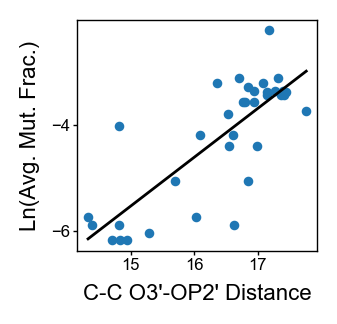

In [143]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_corr_data_cc, ax, "distance", "ln_r_data_mean")

ax.set_xlabel("C-C O3'-OP2' Distance")
ax.set_ylabel("Ln(Avg. Mut. Frac.)")
format_small_plot(ax)
print(r2)

## C-U correlations

In [144]:
# Filter for C-C pair and sort by r2 in descending order
df_cu = df_corr[df_corr["pair"] == "C-U"].sort_values(by="r2", ascending=False)
# Select top 20 rows
top_20_cu = df_cu.head(20)
# Create a table using tabulate
table = tabulate(
    top_20_cu[["atom1", "atom2", "r2", "count"]],
    headers=["Atom 1", "Atom 2", "R2", "Count"],
    tablefmt="pipe",
    floatfmt=".4f",
)
print("Top 20 atom pairs for C-C:")
print(table)

Top 20 atom pairs for C-C:
|      | Atom 1   | Atom 2   |     R2 |   Count |
|-----:|:---------|:---------|-------:|--------:|
| 2060 | N4       | N3       | 0.3998 |      37 |
| 2207 | OP2      | OP1      | 0.3494 |      37 |
| 2209 | OP2      | P        | 0.3332 |      37 |
| 2208 | OP2      | OP2      | 0.3251 |      37 |
| 2227 | P        | OP1      | 0.3238 |      37 |
| 2228 | P        | OP2      | 0.3158 |      37 |
| 1920 | C4       | N3       | 0.3145 |      37 |
| 2188 | OP1      | OP2      | 0.3123 |      37 |
| 2229 | P        | P        | 0.3066 |      37 |
| 2187 | OP1      | OP1      | 0.2952 |      37 |
| 2189 | OP1      | P        | 0.2815 |      37 |
| 2040 | N3       | N3       | 0.2744 |      37 |
| 2031 | N3       | C2       | 0.2560 |      37 |
| 2196 | OP2      | C5       | 0.2551 |      37 |
| 2071 | O2       | C2       | 0.2501 |      37 |
| 2081 | O2       | O2       | 0.2429 |      37 |
| 2079 | O2       | N1       | 0.2326 |      37 |
| 2038 | N3       | C6 

In [145]:
df_corr_data_cu = df_corr_data.query(
    'pair == "C-U" and atom1 == "N4" and atom2 == "N3"'
).copy()
df_corr_data_cu.sort_values(by="distance", ascending=False, inplace=True)

In [146]:
# Create a table using tabulate for A-A pair with N1 and O2' atoms
table_cu = tabulate(
    df_corr_data_cu[["pdb_name", "distance", "ln_r_data_mean", "pdb_r_pos"]],
    headers=["PDB", "Distance", "ln_r_data", "pdb_r_pos"],
    tablefmt="pipe",
    floatfmt=".4f",
    showindex=False,
)
print("Top 20 entries for C-C pair with O3' and OP2 atoms:")
print(table_cu)

Top 20 entries for C-C pair with O3' and OP2 atoms:
| PDB                                                                 |   Distance |   ln_r_data |   pdb_r_pos |
|:--------------------------------------------------------------------|-----------:|------------:|------------:|
| data/pdbs_w_2bp/CUAAC_GGACG/TWOWAY.3IGI.3-3.GGACG-CUAAC.0.pdb       |     5.1800 |     -3.1334 |          15 |
| data/pdbs_w_2bp/UUCG_UUCG/NWAY.4ERD.0-0-0-0.UU-CG-UU-CG.0.pdb       |     4.8300 |     -4.1104 |          13 |
| data/pdbs_w_2bp/GUA_UCC/TWOWAY.6SPB.1-1.UCC-GUA.0.pdb               |     4.8100 |     -5.0877 |          11 |
| data/pdbs_w_2bp/UUCG_UUCG/NWAY.1QBP.-1-1-2.G-UUC-UUCG.0.pdb         |     4.8100 |     -4.2509 |           5 |
| data/pdbs_w_2bp/UUCG_UUCG/TWOWAY.1QBP.2-2.UUCG-UUCG.1.pdb           |     4.8000 |     -4.1104 |          13 |
| data/pdbs_w_2bp/UUCG_UUCG/NWAY.4ERD.0-0-0-0.UU-CG-UU-CG.0.pdb       |     4.8000 |     -4.2509 |           5 |
| data/pdbs_w_2bp/CCC_GUG/NWAY.4BXX.1-0-0-0.

0.39977757040950834


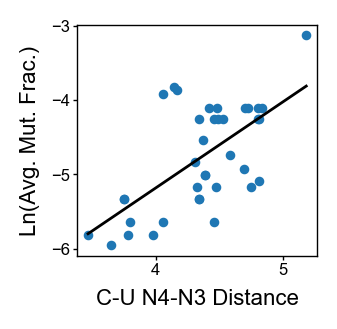

In [147]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_corr_data_cu, ax, "distance", "ln_r_data_mean")

ax.set_xlabel("C-U N4-N3 Distance")
ax.set_ylabel("Ln(Avg. Mut. Frac.)")
format_small_plot(ax)
print(r2)

# Reactivity ratio vs distance

## A-A

In [148]:
# Filter for A-A pair and sort by r2 in descending order
df_aa = df_ratio_corr[df_ratio_corr["pair"] == "A-A"].sort_values(
    by="r2", ascending=False
)
# Select top 20 rows
top_20_aa = df_aa.head(20)
# Create a table using tabulate
table = tabulate(
    top_20_aa[["atom1", "atom2", "r2", "count"]],
    headers=["Atom 1", "Atom 2", "R2", "Count"],
    tablefmt="pipe",
    floatfmt=".4f",
)
print("Top 20 atom pairs for A-A:")
print(table)

Top 20 atom pairs for A-A:
|     | Atom 1   | Atom 2   |     R2 |   Count |
|----:|:---------|:---------|-------:|--------:|
| 338 | O2'      | C6       | 0.3415 |      66 |
| 342 | O2'      | N6       | 0.3330 |      66 |
| 336 | O2'      | C5       | 0.3262 |      66 |
| 343 | O2'      | N7       | 0.2817 |      66 |
| 350 | O2'      | OP2      | 0.2793 |      66 |
|  56 | C2'      | N6       | 0.2778 |      69 |
|  52 | C2'      | C6       | 0.2777 |      69 |
|  92 | C4       | C4       | 0.2698 |      35 |
| 340 | O2'      | N1       | 0.2687 |      66 |
| 248 | N3       | C5       | 0.2682 |      69 |
|  42 | C2       | OP2      | 0.2620 |      69 |
| 275 | N6       | N3       | 0.2620 |      69 |
| 334 | O2'      | C4       | 0.2567 |      66 |
| 254 | N3       | N6       | 0.2564 |      69 |
| 279 | N6       | O2'      | 0.2549 |      66 |
| 339 | O2'      | C8       | 0.2548 |      66 |
| 262 | N3       | OP2      | 0.2517 |      69 |
| 322 | N9       | N9       | 0.2476 |    

In [149]:
df_ratio_corr_data_aa = df_ratio_corr_data.query(
    'pair == "A-A" and atom1 == "O2\'" and atom2 == "C6"'
).copy()
df_ratio_corr_data_aa.sort_values(by="distance", ascending=False, inplace=True)

In [150]:
# Create a table using tabulate for A-A pair with N1 and O2' atoms
table_aa = tabulate(
    df_ratio_corr_data_aa[["pdb_name", "distance", "ratio", "pdb_r_pos"]],
    headers=["PDB", "Distance", "ratio", "pdb_r_pos"],
    tablefmt="pipe",
    floatfmt=".4f",
    showindex=False,
)
print(table_aa)

| PDB                                                                  |   Distance |   ratio |   pdb_r_pos |
|:---------------------------------------------------------------------|-----------:|--------:|------------:|
| data/pdbs_w_2bp/CGACGAAG_CAGAG/TWOWAY.4KQY.3-6.CAGAG-CGACGAAG.0.pdb  |    12.7100 |  0.7952 |           9 |
| data/pdbs_w_2bp/GAAAU_ACAC/TWOWAY.4YAZ.2-3.ACAC-GAAAU.1.pdb          |    11.8900 |  0.9520 |           6 |
| data/pdbs_w_2bp/AAACG_CUAU/TWOWAY.1NJP.2-3.CUAU-AAACG.0.pdb          |    11.8800 |  0.6156 |          14 |
| data/pdbs_w_2bp/CAA_UAG/TWOWAY.6N7R.1-1.UAG-CAA.0.pdb                |    11.6300 |  1.0406 |           4 |
| data/pdbs_w_2bp/CAG_UAG/TWOWAY.5UNE.1-1.UAG-CAG.0.pdb                |    11.5200 |  1.5526 |          11 |
| data/pdbs_w_2bp/GAAGAAG_CGUAAC/TWOWAY.1NJP.4-5.CGUAAC-GAAGAAG.0.pdb  |    11.3600 |  0.8313 |          18 |
| data/pdbs_w_2bp/GGGAAAG_UAACAC/NWAY.2R8S.5-2-0.GGGAAAG-UAAC-AC.0.pdb |    11.3400 |  0.8854 |           7 |
| data/pdb

data/pdbs_w_2bp/AAACG_CUAU/TWOWAY.1NJP.2-3.CUAU-AAACG.0.pdb<br>
data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0.AAUA-UUAGUAC-GG.0.pdb<br>
data/pdbs_w_2bp/CGACGAAG_CAGAG/TWOWAY.4KQY.3-6.CAGAG-CGACGAAG.0.pdb


0.34150858983630217
66


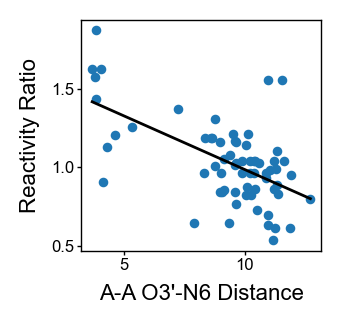

In [151]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_ratio_corr_data_aa, ax, "distance", "ratio")

ax.set_xlabel("A-A O3'-N6 Distance")
ax.set_ylabel("Reactivity Ratio")
format_small_plot(ax)
print(r2)
print(len(df_ratio_corr_data_aa))

## A-C

In [152]:
# Filter for A-A pair and sort by r2 in descending order
df_ac = df_ratio_corr[df_ratio_corr["pair"] == "C-A"].sort_values(
    by="r2", ascending=False
)
# Select top 20 rows
top_20_ac = df_ac.head(20)
# Create a table using tabulate
table = tabulate(
    top_20_ac[["atom1", "atom2", "r2", "count"]],
    headers=["Atom 1", "Atom 2", "R2", "Count"],
    tablefmt="pipe",
    floatfmt=".4f",
)
print("Top 20 atom pairs for A-C:")
print(table)

Top 20 atom pairs for A-C:
|     | Atom 1   | Atom 2   |     R2 |   Count |
|----:|:---------|:---------|-------:|--------:|
| 790 | O2'      | OP2      | 0.6532 |      48 |
| 548 | C2'      | OP2      | 0.6452 |      48 |
| 768 | O2       | OP2      | 0.6301 |      48 |
| 791 | O2'      | P        | 0.6266 |      48 |
| 812 | O3'      | OP2      | 0.6107 |      48 |
| 526 | C2       | OP2      | 0.6072 |      48 |
| 504 | C1'      | OP2      | 0.5995 |      48 |
| 789 | O2'      | OP1      | 0.5958 |      48 |
| 769 | O2       | P        | 0.5936 |      48 |
| 549 | C2'      | P        | 0.5916 |      48 |
| 570 | C3'      | OP2      | 0.5715 |      48 |
| 547 | C2'      | OP1      | 0.5569 |      48 |
| 767 | O2       | OP1      | 0.5500 |      48 |
| 702 | N1       | OP2      | 0.5459 |      48 |
| 813 | O3'      | P        | 0.5407 |      48 |
| 614 | C4'      | OP2      | 0.5328 |      48 |
| 505 | C1'      | P        | 0.5299 |      48 |
| 834 | O4'      | OP2      | 0.5293 |    

In [153]:
df_ratio_corr_data_ac = df_ratio_corr_data.query(
    'pair == "C-A" and atom1 == "O2\'" and atom2 == "OP2"'
).copy()
df_ratio_corr_data_ac.sort_values(by="distance", ascending=False, inplace=True)

In [154]:
# Create a table using tabulate for A-A pair with N1 and O2' atoms
table_ac = tabulate(
    df_ratio_corr_data_ac[["pdb_name", "distance", "ratio", "pdb_r_pos"]],
    headers=["PDB", "Distance", "ratio", "pdb_r_pos"],
    tablefmt="pipe",
    floatfmt=".4f",
    showindex=False,
)
print(table_ac)

| PDB                                                                |   Distance |   ratio |   pdb_r_pos |
|:-------------------------------------------------------------------|-----------:|--------:|------------:|
| data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb          |    18.6300 |  0.4220 |           4 |
| data/pdbs_w_2bp/AGGACC_GAGAAU/TWOWAY.5XYM.4-4.AGGACC-GAGAAU.0.pdb  |    17.9000 |  0.7982 |           7 |
| data/pdbs_w_2bp/GAUGAAA_UAACC/NWAY.5XTM.3-3-0.UGAAA-UAACC-GA.0.pdb |    17.3700 |  0.9344 |          17 |
| data/pdbs_w_2bp/UAG_UCA/TWOWAY.5XXU.1-1.UAG-UCA.0.pdb              |    17.3400 |  1.1878 |          11 |
| data/pdbs_w_2bp/GACC_GACC/TWOWAY.1L9A.2-2.GACC-GACC.0.pdb          |    17.1800 |  1.0714 |          13 |
| data/pdbs_w_2bp/ACG_CAU/TWOWAY.4M4O.1-1.ACG-CAU.0.pdb              |    17.1600 |  0.9590 |           4 |
| data/pdbs_w_2bp/GAA_UCC/TWOWAY.4P95.1-1.GAA-UCC.0.pdb              |    16.5500 |  1.1059 |          11 |
| data/pdbs_w_2bp/AAU_ACU/TW

data/pdbs_w_2bp/GCAC_GGAU/TWOWAY.6ZVI.2-2.GGAU-GCAC.0.pdb<br>
data/pdbs_w_2bp/AAGCAG_UCAGGU/TWOWAY.1LNT.4-4.UCAGGU-AAGCAG.0.pdb<br>

0.6532282028839683


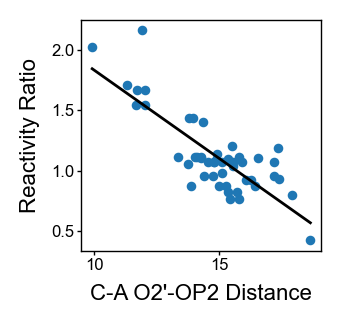

In [155]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_ratio_corr_data_ac, ax, "distance", "ratio")

ax.set_xlabel("C-A O2'-OP2 Distance")
ax.set_ylabel("Reactivity Ratio")
format_small_plot(ax)
print(r2)

## C-C


In [156]:
# Filter for A-A pair and sort by r2 in descending order
df_cc = df_ratio_corr[df_ratio_corr["pair"] == "C-C"].sort_values(
    by="r2", ascending=False
)
# Select top 20 rows
top_20_cc = df_cc.head(100)
# Create a table using tabulate
table = tabulate(
    top_20_cc[["atom1", "atom2", "r2", "count"]],
    headers=["Atom 1", "Atom 2", "R2", "Count"],
    tablefmt="pipe",
    floatfmt=".4f",
)
print("Top 20 atom pairs for C-C:")
print(table)

Top 20 atom pairs for C-C:
|      | Atom 1   | Atom 2   |     R2 |   Count |
|-----:|:---------|:---------|-------:|--------:|
| 1208 | O3'      | C4       | 0.4320 |      35 |
| 1222 | O3'      | OP2      | 0.4285 |      35 |
|  988 | C3'      | C4       | 0.4202 |      35 |
| 1002 | C3'      | OP2      | 0.4175 |      35 |
|  968 | C2'      | C4       | 0.4167 |      35 |
| 1194 | O2'      | N3       | 0.4161 |      35 |
| 1188 | O2'      | C4       | 0.4119 |      35 |
| 1214 | O3'      | N3       | 0.4118 |      35 |
|  975 | C2'      | N4       | 0.4102 |      35 |
| 1122 | N1       | OP2      | 0.4092 |      35 |
|  982 | C2'      | OP2      | 0.4087 |      35 |
| 1195 | O2'      | N4       | 0.4066 |      35 |
| 1210 | O3'      | C5       | 0.4055 |      35 |
| 1115 | N1       | N4       | 0.4048 |      35 |
|  995 | C3'      | N4       | 0.4044 |      35 |
| 1215 | O3'      | N4       | 0.4031 |      35 |
|  935 | C1'      | N4       | 0.4024 |      35 |
| 1042 | C4'      | OP2

In [157]:
df_ratio_corr_data_cc = df_ratio_corr_data.query(
    'pair == "C-C" and atom1 == "O3\'" and atom2 == "C4"'
).copy()
df_ratio_corr_data_cc.sort_values(by="distance", ascending=False, inplace=True)

In [158]:
table_cc = tabulate(
    df_ratio_corr_data_cc[["pdb_name", "distance", "ratio", "pdb_r_pos"]],
    headers=["PDB", "Distance", "ratio", "pdb_r_pos"],
    tablefmt="pipe",
    floatfmt=".4f",
    showindex=False,
)
print(len(df_ratio_corr_data_cc))
print(table_cc)

35
| PDB                                                                |   Distance |   ratio |   pdb_r_pos |
|:-------------------------------------------------------------------|-----------:|--------:|------------:|
| data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QLM.0-4-2.AC-GGACCC-GCUA.0.pdb |    12.3700 |  0.5770 |          17 |
| data/pdbs_w_2bp/CGACCA_UCUUAG/TWOWAY.2OIU.4-4.CGACCA-UCUUAG.0.pdb  |    12.2100 |  0.5657 |           7 |
| data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0.UAAC-GGACCC-GC.0.pdb |    11.9600 |  0.5770 |          17 |
| data/pdbs_w_2bp/ACCC_GACU/TWOWAY.3WBM.2-2.GACU-ACCC.0.pdb          |    11.9500 |  0.9859 |          13 |
| data/pdbs_w_2bp/CCG_CCG/TWOWAY.1NJP.1-1.CCG-CCG.0.pdb              |    11.8700 |  1.0260 |           4 |
| data/pdbs_w_2bp/CCG_CCG/TWOWAY.4IOA.1-1.CCG-CCG.0.pdb              |    11.8100 |  1.0260 |           4 |
| data/pdbs_w_2bp/CCCG_CCCG/NWAY.5EW4.0-0-2.CG-CC-CCCG.0.pdb         |    11.7300 |  0.5866 |           5 |
| data/pdbs_w_2bp/CCCG_CC

data/pdbs_w_2bp/CGACCA_UCUUAG/TWOWAY.2OIU.4-4.CGACCA-UCUUAG.0.pdb<br>
data/pdbs_w_2bp/UUCUA_UUCUA/TWOWAY.5BTM.3-3.UUCUA-UUCUA.0.pdb<br>
data/pdbs_w_2bp/CCCG_CCCG/NWAY.5EW4.0-0-2.CG-CC-CCCG.0.pdb<br>

0.431990425151461


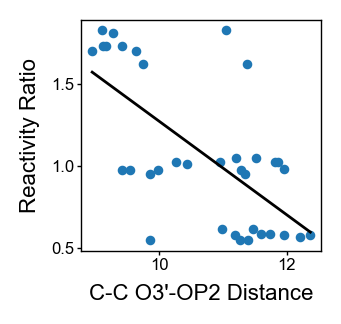

In [159]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)

# Call the function with the dataframe
r2 = create_scatter_plot_w_regression(df_ratio_corr_data_cc, ax, "distance", "ratio")

ax.set_xlabel("C-C O3'-OP2 Distance")
ax.set_ylabel("Reactivity Ratio")
format_small_plot(ax)
print(r2)